In [7]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.applications import MobileNetV2  
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from pathlib import Path
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.regularizers import l2  # Added for L2 reg
import matplotlib.pyplot as plt
from PIL import Image

# Use relative path (assume notebook is in project dir; adjust as needed)
base_path = base_path = Path(r"C:\\Users\\amand\\Desktop\\tb_project\\TB_Chest_Radiography_Database")

files = []
labels = []
for img_path in base_path.rglob("*.png"):
    files.append(str(img_path))
    labels.append(0 if img_path.parent.name == "Normal" else 1)  # 0=Normal, 1=TB

# Stratified split (80% train, 20% val)
train_files, val_files, train_labels, val_labels = train_test_split(
    files, labels, test_size=0.2, random_state=42, stratify=labels
)

In [8]:
IMG_SIZE = 300
BATCH_SIZE = 32
train_df = pd.read_csv(r"C:\Users\amand\Desktop\tb_project\.venv\train_tb_dataset.csv")  # Relative path
val_df = pd.read_csv(r"C:\Users\amand\Desktop\tb_project\.venv\val_tb_dataset.csv")  # Renamed test_df to val_df for clarity

In [9]:
val_df.value_counts()  # Added ()

path                                                                                              label       
C:\Users\amand\Desktop\tb_project\TB_Chest_Radiography_Database\Normal\Normal-10.png              Normal          1
C:\Users\amand\Desktop\tb_project\TB_Chest_Radiography_Database\Normal\Normal-1001.png            Normal          1
C:\Users\amand\Desktop\tb_project\TB_Chest_Radiography_Database\Normal\Normal-1008.png            Normal          1
C:\Users\amand\Desktop\tb_project\TB_Chest_Radiography_Database\Normal\Normal-1012.png            Normal          1
C:\Users\amand\Desktop\tb_project\TB_Chest_Radiography_Database\Normal\Normal-1015.png            Normal          1
                                                                                                                 ..
C:\Users\amand\Desktop\tb_project\TB_Chest_Radiography_Database\Tuberculosis\Tuberculosis-75.png  Tuberculosis    1
C:\Users\amand\Desktop\tb_project\TB_Chest_Radiography_Database\Tuberculosis\

In [10]:
# Convert label to string required for generator
train_df['label'] = train_df['label'].astype(str)
val_df['label'] = val_df['label'].astype(str)

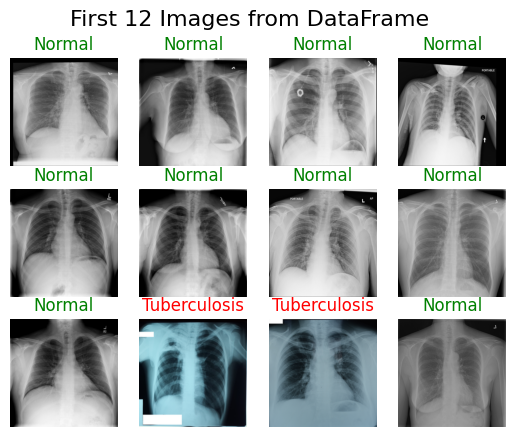

In [11]:
# Just change train_df → val_df if you want validation
for i in range(12):
    img = Image.open(train_df.iloc[i]['path'])        # open image
    plt.subplot(3, 4, i+1)
    plt.imshow(img, cmap='gray')
    plt.title(train_df.iloc[i]['label'], color='red' if 'Tuberc' in train_df.iloc[i]['label'] else 'green')
    plt.axis('off')

plt.suptitle("First 12 Images from DataFrame", fontsize=16)
plt.show()

In [12]:
#Imbalance Check
print("Class distribution(IMBALANCE CHECK)")
print(train_df['label'].value_counts().sort_index())

Class distribution(IMBALANCE CHECK)
label
Normal          2800
Tuberculosis     560
Name: count, dtype: int64


In [13]:
#class weights
class_weights=compute_class_weight('balanced',classes=np.unique(train_df['label']),y=train_df['label'])
class_weights_dict=dict(enumerate(class_weights))

In [14]:
train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip=True,  # Added: Helps with orientation variance
    brightness_range=[0.8, 1.2],
    channel_shift_range=10.0,
    fill_mode='nearest',
)

# Validation: ONLY preprocessing, NO augmentation
val_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input
)

# Training generator (no subset needed, as we use pre-split train_df)
train_gen = train_datagen.flow_from_dataframe(
    dataframe=train_df,
    x_col='path',
    y_col='label',
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='binary',
    shuffle=True,
    seed=42
)  # Removed subset='training'

# Validation generator
valid_gen = val_datagen.flow_from_dataframe(
    dataframe=val_df,
    x_col='path',
    y_col='label',
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='binary',
    shuffle=False,
    seed=42
)

# No need for separate test_gen (use valid_gen for eval)

Found 3360 validated image filenames belonging to 2 classes.
Found 840 validated image filenames belonging to 2 classes.


In [10]:
print("Train samples :", train_gen.samples)
print("Valid samples :", valid_gen.samples)
print("Train classes :", train_gen.class_indices)
print("Valid classes :", valid_gen.class_indices)

Train samples : 3360
Valid samples : 840
Train classes : {'Normal': 0, 'Tuberculosis': 1}
Valid classes : {'Normal': 0, 'Tuberculosis': 1}


In [11]:
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(IMG_SIZE, IMG_SIZE, 3))  # Smaller model
base_model.trainable = False

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.6)(x)  # Increased dropout
x = Dense(512, activation='relu', kernel_regularizer=l2(0.001))(x)  # Added L2 reg
x = Dropout(0.4)(x)  # Increased dropout
predictions = Dense(1, activation='sigmoid')(x)
model = Model(inputs=base_model.input, outputs=predictions)

# Unfreeze fewer layers (last 20 instead of 40)
base_model.trainable = True
for layer in base_model.layers[:-20]:
    layer.trainable = False

model.compile(optimizer=Adam(1e-5), loss=tf.keras.losses.binary_focal_crossentropy, metrics=[tf.keras.metrics.AUC(name='auc'), tf.keras.metrics.Precision(), tf.keras.metrics.Recall()])

C:\Users\amand\AppData\Local\Temp\ipykernel_10436\2812454162.py:1: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(IMG_SIZE, IMG_SIZE, 3))  # Smaller model


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 13s 1us/step


In [12]:
model.fit(
    train_gen,
    validation_data=valid_gen,
    epochs=100,
    steps_per_epoch=len(train_gen),
    validation_steps=len(valid_gen),
    class_weight=class_weights_dict,
    callbacks = [
        EarlyStopping(
            monitor='val_loss',      # More stable than AUC near 1.0
            mode='min',
            patience=8,
            min_delta=0.0001,
            restore_best_weights=True,
            verbose=1
        ),
        ReduceLROnPlateau(
            monitor='val_loss',
            mode='min',
            factor=0.5,
            patience=4,
            verbose=1
        ),
        tf.keras.callbacks.ModelCheckpoint('best_model.keras', save_best_only=True, monitor='val_loss', mode='min')
],
    verbose=1
)

Epoch 1/100
105/105 ━━━━━━━━━━━━━━━━━━━━ 277s 3s/step - auc: 0.5917 - loss: 1.0179 - precision: 0.2181 - recall: 0.5000 - val_auc: 0.8454 - val_loss: 0.8293 - val_precision: 0.7037 - val_recall: 0.5429 - learning_rate: 1.0000e-05
Epoch 2/100
105/105 ━━━━━━━━━━━━━━━━━━━━ 229s 2s/step - auc: 0.7517 - loss: 0.9200 - precision: 0.3048 - recall: 0.6750 - val_auc: 0.9723 - val_loss: 0.7783 - val_precision: 1.0000 - val_recall: 0.6000 - learning_rate: 1.0000e-05
Epoch 3/100
105/105 ━━━━━━━━━━━━━━━━━━━━ 197s 2s/step - auc: 0.8573 - loss: 0.8652 - precision: 0.4179 - recall: 0.7911 - val_auc: 0.9946 - val_loss: 0.7626 - val_precision: 1.0000 - val_recall: 0.5786 - learning_rate: 1.0000e-05
Epoch 4/100
105/105 ━━━━━━━━━━━━━━━━━━━━ 195s 2s/step - auc: 0.9011 - loss: 0.8369 - precision: 0.4800 - recall: 0.8357 - val_auc: 0.9983 - val_loss: 0.7550 - val_precision: 1.0000 - val_recall: 0.6071 - learning_rate: 1.0000e-05
Epoch 5/100
105/105 ━━━━━━━━━━━━━━━━━━━━ 190s 2s/step - auc: 0.9316 - loss: 0.81

In [74]:
# Load the best model so far (from your ModelCheckpoint)
model = tf.keras.models.load_model('best_tb_model.keras')  # if you had save_best_only=True

# OR if you didn't save yet, just use current model (it's probably already very good at epoch 53)

In [13]:
model.save('my_model.keras')

In [3]:
# Cell 2: Load your saved model
model = tf.keras.models.load_model('my_model.keras')
print("Model loaded successfully!")
model.summary()

Model loaded successfully!


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 300, 300,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 150, 150,  │        864 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 150, 150,  │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 150, 150,  │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 150, 150,  │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 150, 150,  │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 150, 150,  │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 150, 150,  │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 150, 150,  │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 150, 150,  │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 150, 150,  │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 150, 150,  │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 151, 151,  │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 75, 75,    │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 75, 75,    │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 75, 75,    │          0 │ block_1_depthwis… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 75, 75,    │      2,304 │ block_1_depthwis

 Total params: 6,639,301 (25.33 MB)

 Trainable params: 1,862,465 (7.10 MB)

 Non-trainable params: 1,051,904 (4.01 MB)

 Optimizer params: 3,724,932 (14.21 MB)

In [15]:
# Cell: Basic evaluation
val_loss, val_auc, val_precision, val_recall = model.evaluate(valid_gen, steps=len(valid_gen))
print(f"Validation Loss: {val_loss:.4f}")
print(f"Validation AUC: {val_auc:.4f}")
print(f"Validation Precision: {val_precision:.4f}")
print(f"Validation Recall: {val_recall:.4f}")

27/27 ━━━━━━━━━━━━━━━━━━━━ 34s 1s/step - auc: 0.9999 - loss: 0.3341 - precision: 1.0000 - recall: 0.9357
Validation Loss: 0.3341
Validation AUC: 0.9999
Validation Precision: 1.0000
Validation Recall: 0.9357
